# MANIA results for three subject
In the figure below, we look at : __Threshold, Density, Assymetry__. Their relationship together and the optimum operating point metrics. The results are shown for three subjects

In [70]:
from py2neo import Node, Relationship, Graph
from numpy.random import rand
import numpy as num
from bokeh.plotting import output_notebook,figure, show
from bokeh.layouts import row,column,gridplot
from bokeh.models import Label
import numpy as np
import matplotlib.pyplot as plt
from curve import *
from bokeh.models import Span
output_notebook()

Loading BokehJS ...

In [71]:
graph = Graph()

In [97]:
def parseSubjNEO(sub,hem):
	c = '''match (n:ROI)-[r:NOS]->(m:ROI) where r.SUBJECT=XXX and n.name="RRR" and m.name="ZZZ"
	return r._weight as w'''.replace('XXX',str(sub)).replace('HHH',hem)
	W = {}
	nroi = 180
	for i in range(nroi):
		for j in range(nroi):
			if (i==j):continue
			q1 = 'L'+str(i+1)
			q2 = 'L'+str(j+1)
			c1 = c.replace('RRR',q1)
			c2 = c1.replace('ZZZ',q2)
			A = graph.run(c2)
			vox = [0]
			for line in A:
				vox=line['w']
				if len(vox) == 0:
					vox = [0]
				break
			W[(i+1,j+1)]=vox
	return W

In [98]:
W = parseSubjNEO(421226,"L")

In [74]:
def vox_roi(W,th):
	K={}
	for idk in W.keys():
		tup=num.array(W[idk])
		tmp=num.zeros(len(tup))
		tmp[tup > th]=1
		K[idk]=tmp
	return K

In [75]:
def roi_roi(K):
	net = num.zeros((180,180))
	for idk in K.keys():
		W=K[idk]
		tmp=num.sum(W,0)
		net[idk[0]-1,idk[1]-1]= 1 if tmp>.5 else 0 
	return net

In [76]:
K = vox_roi(W,2500)
net = roi_roi(K)

In [77]:
num.sum(net)

1083.0

In [99]:
def brainMap(W,ns):
	nroi=180
	B=num.zeros((nroi,nroi))
	tpe=nroi*nroi-nroi	# total possible edges
	res=[()]*(ns-1)
	q = 0
	for T in tqdm(reversed(range(500,ns)), total = ns-1):
			K=vox_roi(W,T)
			BM=roi_roi(K)
			den=density(BM)
			met=NAR(BM)
			res[q]=(BM,met,den,T)
			q = q + 1
	return res

In [100]:
res = brainMap(W,5000)

 90%|█████████ | 4500/4999 [31:14<03:27,  2.40it/s]


In [60]:
from tqdm import tqdm
res = brainMap(W,5000)

100%|██████████| 4999/4999 [25:24<00:00,  3.28it/s]


In [96]:
d = [xx[2] for xx in res[0:4499]]
met = [xx[1] for xx in res[0:4499]]
p1 = figure()
p1.line(d,met)
show(p1)

### Distance vs connection strength plot
The figure below shows the distance vs connection strength for the two target ROIs ```L4``` and ```L121```.

In [103]:
d = [xx[2] for xx in res[10:4499]]
met = [xx[1] for xx in res[10:4499]]
p1 = figure()
p1.line(d,met)
show(p1)

> It seems that target ROI ```L121``` and ```L4``` are adjacent to ```L1```, and that is why they contianed most of the strongly connected seeds. 

---

//// Past ///

# ROI to ROI Distance

> The sample results in this sections are all from seeds in ROI L1 and subject 1881(L for left hemisphere and 1 is the ROI identifier). Also all analysis as discussed previously are done seperately per hemisphere.

Since in MANIA 2.0, we are proposing a distance correction the first step is to define the distance metric itself. The starting point to define such a metric is $A_i(j,k)$ i.e., the distance of seed $j$ in ROI $i$ from target ROI $k$. First we analyze the $A_i(j,k)$ for pair $i=0,k=3$, the connection strength of these pairs are very strong (4665 conncting streamlines out of 5000)

| Seed ROI | Target ROI | Number of connecting streamlines (strongest connection) |
|--- | --- | --- |
|L1 | L4 | 4665/5000 |

In [4]:
from utils import *
import matplotlib.pyplot as plt
%matplotlib inline
L = readS2R_L() # Read all distances
L = L[:,3]; # Get strongest connected ROI distances (L1 to L4) - python indecies start from 0
L = L.flatten()
L = L[num.nonzero(L)] # Get distances from all connected seeds
# some statistics for seed to target ROI distance from L1 to L4
print("Mean Distance:%8.2f" % num.mean(L))
print("Median Distance:%8.2f"%num.median(L))
print("Min Distance:%8.2f"%num.min(L))
print("Max Distance:%8.2f"%num.max(L))

Mean Distance:   23.30
Median Distance:   24.34
Min Distance:    0.30
Max Distance:   51.90


### Distance PDF
Figure below illustrate the PDF of distances (from all seeds of L1 to target ROI L4)

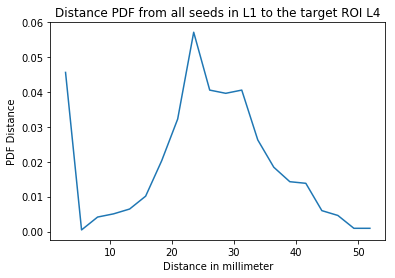

In [5]:
y,x = pdf(L)
plt.plot(x,y)
plt.xlabel("Distance in millimeter")
plt.ylabel("PDF Distance")
plt.title("Distance PDF from all seeds in L1 to the target ROI L4")
print()

# What Distance metric?
### Mean/ Mediam or strongest connection distance
The above analysis was repeated for 9 random target ROIs from R1. PDF of these distance are plotted below. Also in these plots you can see:
1. Mean distance
2. Median distance
3. Distance from the strongest connected seed

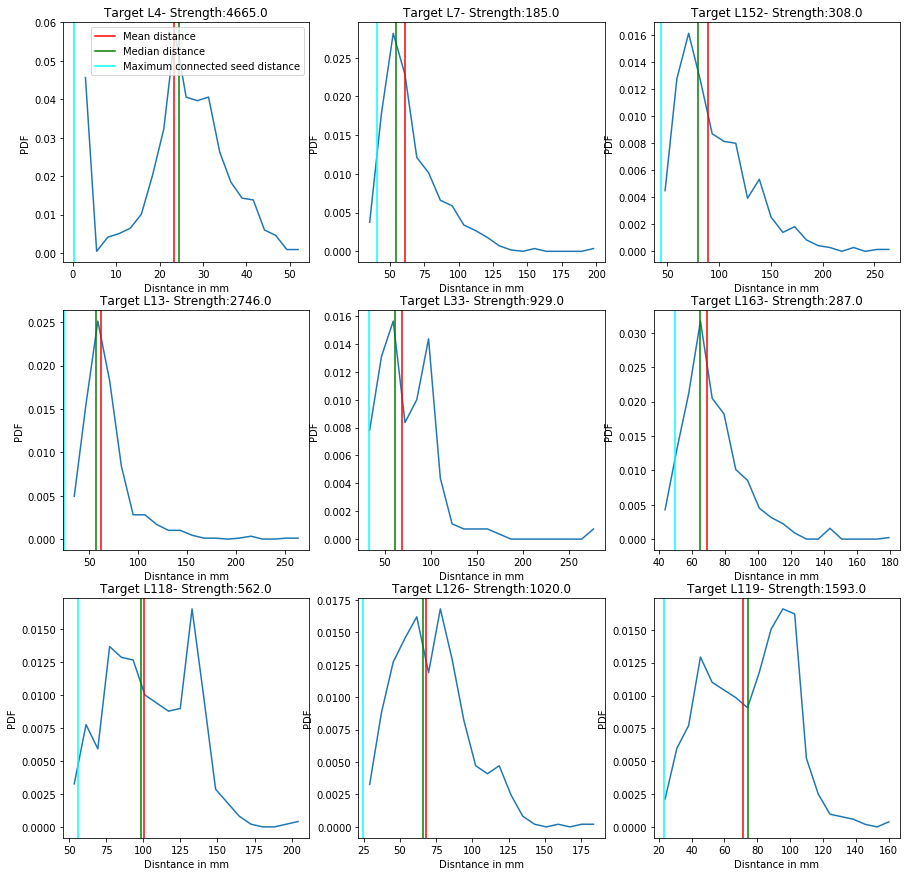

In [6]:
D,X,C,Z = randomDisPDF()
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(15,15))
i = 0
for row in ax:
    for col in row:
        col.plot(X[i,:],D[i,:])
        col.set_xlabel("Disntance in mm")
        col.set_ylabel("PDF")
        col.set_title("Target L"+str(int(C[i][0])) + "- Strength:" +str(C[i][1]))
        col.axvline(Z[i][0], color="red",label='Mean distance')
        col.axvline(Z[i][1], color="green",label='Median distance')
        col.axvline(Z[i][2], color="cyan",label='Maximum connected seed distance')
        if i == 0:
            col.legend()
        i = i + 1

> The strongest connected seed is always **much closer** to the target ROI.

In [3]:
hdf = read_hdf('all.h5','sub/L1/p')

TypeError: cannot create a storer if the object is not existing nor a value are passed

In [101]:
num.log(5000)

8.5171931914162382